<a href="https://colab.research.google.com/github/Abhyu-S/24065008-CSOC-IG/blob/main/mobilenet_v2_quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.quantization
import time
import os
import numpy as np
import matplotlib.pyplot as plt

# ==================================================================
# 1. SETUP
# ==================================================================
# For reproducibility
torch.manual_seed(1910)
# Set number of epochs for a more meaningful training session
NUM_EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# ==================================================================
# 2. DATA LOADING
# ==================================================================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)
print("CIFAR-10 dataset loaded.")


100%|██████████| 170M/170M [00:03<00:00, 47.9MB/s]


CIFAR-10 dataset loaded.


In [3]:
# ==================================================================
# 3. MODEL DEFINITION AND MODIFICATION
# ==================================================================
class QuantizableModel(nn.Module):
    def __init__(self, model_fp32):
        super().__init__()
        self.quant = torch.quantization.QuantStub()
        self.model_fp32 = model_fp32
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.model_fp32(x)
        x = self.dequant(x)
        return x

# Create the standard floating-point model
float_model = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')
num_features = float_model.classifier[1].in_features
float_model.classifier = nn.Linear(num_features, 10)

# Fix for residual connections
for module in float_model.modules():
    if isinstance(module, torchvision.models.mobilenetv2.InvertedResidual):
        module.skip_add = nn.quantized.FloatFunctional()
        def new_forward(self, x):
            if self.use_res_connect:
                return self.skip_add.add(x, self.conv(x))
            else:
                return self.conv(x)
        module.forward = new_forward.__get__(module, type(module))

# Wrap the model
quantizable_model = QuantizableModel(model_fp32=float_model)
print("Quantizable model created and skip connections fixed.")


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 61.5MB/s]

Quantizable model created and skip connections fixed.


In [4]:
# ==================================================================
# 4. MODEL PREPARATION FOR QAT
# ==================================================================
quantizable_model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
qat_model = torch.quantization.prepare_qat(quantizable_model.train())
print("Model prepared for QAT.")

/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Model prepared for QAT.


In [5]:
# ==================================================================
# 5. TRAINING LOOP
# ==================================================================
qat_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(qat_model.parameters(), lr=0.001, momentum=0.9)

print(f"\nStarting QAT training for {NUM_EPOCHS} epochs on {device}...")
for epoch in range(NUM_EPOCHS):
    qat_model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = qat_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Loss: {running_loss/len(trainloader):.3f}")

print("Training complete.")



Starting QAT training for 10 epochs on cuda...
Epoch [1/10] Loss: 0.774
Epoch [2/10] Loss: 0.356
Epoch [3/10] Loss: 0.272
Epoch [4/10] Loss: 0.228
Epoch [5/10] Loss: 0.192
Epoch [6/10] Loss: 0.164
Epoch [7/10] Loss: 0.144
Epoch [8/10] Loss: 0.131
Epoch [9/10] Loss: 0.116
Epoch [10/10] Loss: 0.099
Training complete.


In [6]:
# ==================================================================
# 6. FINAL CONVERSION
# ==================================================================
qat_model.to('cpu')
quantized_integer_model = torch.quantization.convert(qat_model.eval())
print("\nModel successfully converted to a final integer model.")

/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/utils.py:408: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(



Model successfully converted to a final integer model.


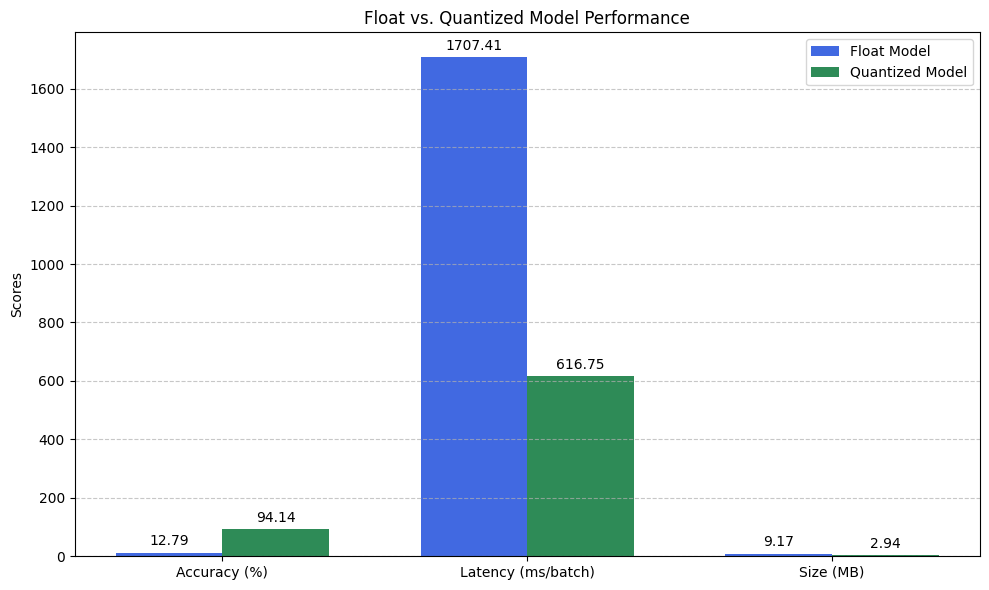

In [7]:
# ==================================================================
# 7. PERFORMANCE EVALUATION & COMPARISON
# ==================================================================

# Helper function to get model size
def get_model_size_mb(model):
    torch.save(model.state_dict(), "temp.p")
    size_mb = os.path.getsize("temp.p")/1e6
    os.remove("temp.p")
    return size_mb

# Helper function to evaluate accuracy and latency
def evaluate_model(model, data_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    # Timing
    start_time = time.time()
    if device == 'cuda':
        torch.cuda.synchronize()

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if device == 'cuda':
        torch.cuda.synchronize()
    end_time = time.time()

    total_time = end_time - start_time
    avg_latency_ms = (total_time / len(data_loader)) * 1000
    accuracy = 100 * correct / total
    return accuracy, avg_latency_ms

# --- Run Evaluations ---
# Note: Quantized integer models run on CPU
quant_accuracy, quant_latency = evaluate_model(quantized_integer_model, testloader, device='cpu')
quant_size = get_model_size_mb(quantized_integer_model)

# Float model can be evaluated on CPU or GPU
float_accuracy, float_latency = evaluate_model(float_model, testloader, device='cpu')
float_size = get_model_size_mb(float_model)


# ==================================================================
# 8. VISUALIZATION
# ==================================================================
labels = ['Accuracy (%)', 'Latency (ms/batch)', 'Size (MB)']
quant_metrics = [quant_accuracy, quant_latency, quant_size]
float_metrics = [float_accuracy, float_latency, float_size]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, float_metrics, width, label='Float Model', color='royalblue')
rects2 = ax.bar(x + width/2, quant_metrics, width, label='Quantized Model', color='seagreen')

# Add text for labels, title and axes ticks
ax.set_ylabel('Scores')
ax.set_title('Float vs. Quantized Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')

fig.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()